In [1]:
# Copyright (c) 2024，WuChao D-Robotics.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import cv2
import numpy as np
from scipy.special import softmax
from scipy.special import expit as sigmoid
from time import time
import bpu_infer_lib  # Model Zoo Python API

In [2]:
coco_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", 
    "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", 
    "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", 
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", 
    "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", 
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", 
    "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", 
    "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
    ]

rdk_colors = [
    (56, 56, 255), (151, 157, 255), (31, 112, 255), (29, 178, 255),(49, 210, 207), (10, 249, 72), (23, 204, 146), (134, 219, 61),
    (52, 147, 26), (187, 212, 0), (168, 153, 44), (255, 194, 0),(147, 69, 52), (255, 115, 100), (236, 24, 0), (255, 56, 132),
    (133, 0, 82), (255, 56, 203), (200, 149, 255), (199, 55, 255)]

def draw_detection(img: np.array, 
                   box,
                   score: float, 
                   class_id: int) -> None:
    x1, y1, x2, y2 = box
    color = rdk_colors[class_id%20]
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    label = f"{coco_names[class_id]}: {score:.2f}"
    (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    label_x = x1
    label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10
    cv2.rectangle(
        img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color, cv2.FILLED
    )
    cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

# matplotlib 绘制图像到 Jupyter Web
from  matplotlib import pyplot as plt
%matplotlib inline
def cv2_img2plt_img(cv2_img: np.ndarray)-> np.ndarray:
    if cv2_img.ndim==3: # Color image, Convert BGR to RGB
        return cv2_img[:,:,::-1] 
    else: # Grayscale image
        return cv2_img

def jshow(cv2_img: np.ndarray, size: int = 4)-> None:
    plt.figure(figsize=(size, size))
    plt.imshow(cv2_img2plt_img(cv2_img), plt.cm.gray)
    plt.show()

def bgr2nv12_opencv(image: np.ndarray) -> np.ndarray:
    height, width = image.shape[0], image.shape[1]
    area = height * width
    yuv420p = cv2.cvtColor(image, cv2.COLOR_BGR2YUV_I420).reshape((area * 3 // 2,))
    y = yuv420p[:area]
    uv_planar = yuv420p[area:].reshape((2, area // 4))
    uv_packed = uv_planar.transpose((1, 0)).reshape((area // 2,))

    nv12 = np.zeros_like(yuv420p)
    nv12[:height * width] = y
    nv12[height * width:] = uv_packed
    return nv12

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
# 导入bin模型
model_path = "models/yolov5n_tag_v7.0_detect_640x640_bayese_nv12.bin"
begin_time = time()
inf = bpu_infer_lib.Infer(False)
inf.load_model(model_path)
print("\033[1;31m" + f"Load D-Robotics Quantize model time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

Load D-Robotics Quantize model time = 136.07 msThe model path is valid and points to a regular file.

[BPU_PLAT]BPU Platform Version(1.3.6)!
[HBRT] set log level as 0. version = 3.15.54.0
[DNN] Runtime version = 1.23.10_(3.15.54 HBRT)
[A][DNN][packed_model.cpp:247][Model](2024-09-11,21:39:52.263.929) [HorizonRT] The model builder version = 1.23.8


In [4]:
# 配置项
conf=0.25
iou=0.45
nc = 80
anchors = np.array([
                    [10,13, 16,30, 33,23],  # P3/8
                    [30,61, 62,45, 59,119],  # P4/16
                    [116,90, 156,198, 373,326],  # P5/32
                   ])# .reshape(3, 3, 2)
strides = np.array([8, 16, 32])
input_h, input_w = 640, 640
print(f"{input_h=}  {input_w=}")

# strides的grid网格, 只需要生成一次
s_grid = np.stack([np.tile(np.linspace(0.5, input_w//strides[0] - 0.5, input_w//strides[0]), reps=input_h//strides[0]), 
                     np.repeat(np.arange(0.5, input_h//strides[0] + 0.5, 1), input_w//strides[0])], axis=0).transpose(1,0)
s_grid = np.hstack([s_grid, s_grid, s_grid]).reshape(-1, 2)

m_grid = np.stack([np.tile(np.linspace(0.5, input_w//strides[1] - 0.5, input_w//strides[1]), reps=input_h//strides[1]), 
                     np.repeat(np.arange(0.5, input_h//strides[1] + 0.5, 1), input_w//strides[1])], axis=0).transpose(1,0)
m_grid = np.hstack([m_grid, m_grid, m_grid]).reshape(-1, 2)

l_grid = np.stack([np.tile(np.linspace(0.5, input_w//strides[2] - 0.5, input_w//strides[2]), reps=input_h//strides[2]), 
                     np.repeat(np.arange(0.5, input_h//strides[2] + 0.5, 1), input_w//strides[2])], axis=0).transpose(1,0)
l_grid = np.hstack([l_grid, l_grid, l_grid]).reshape(-1, 2)

print(f"{s_grid.shape = }  {m_grid.shape = }  {l_grid.shape = }")

# 用于广播的anchors只需要生成一次
s_anchors = np.tile(anchors[0], input_w//strides[0] * input_h//strides[0]).reshape(-1, 2)
m_anchors = np.tile(anchors[1], input_w//strides[1] * input_h//strides[1]).reshape(-1, 2)
l_anchors = np.tile(anchors[2], input_w//strides[2] * input_h//strides[2]).reshape(-1, 2)

print(f"{s_anchors.shape = }  {m_anchors.shape = }  {l_anchors.shape = }")

input_h=640  input_w=640
s_grid.shape = (19200, 2)  m_grid.shape = (4800, 2)  l_grid.shape = (1200, 2)
s_anchors.shape = (19200, 2)  m_anchors.shape = (4800, 2)  l_anchors.shape = (1200, 2)


cv2.imread time = 20.26 ms
img.shape = (1080, 810, 3)


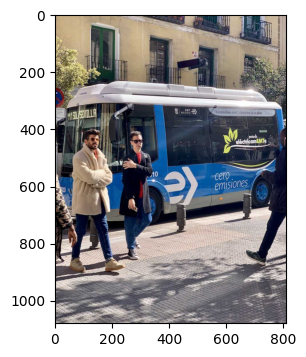

pre process time = 11.22 ms
input_tensor.shape = (614400,)


In [5]:
# 读取一张bgr8格式的图像, 并进行可视化
begin_time = time()
img = cv2.imread("../../../resource/assets/bus.jpg")
print("\033[1;31m" + f"cv2.imread time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")
print(f"{img.shape = }")
jshow(img)

# 利用resize的方式进行前处理, 准备nv12的输入数据
# 注: 如果在yaml文件中配置为nchw-rgb输入, 可使用OpenCV和numpy准备输入数据
begin_time = time()
input_tensor = cv2.resize(img, (input_h, input_w), interpolation=cv2.INTER_NEAREST) # 利用resize重新开辟内存节约一次
# input_tensor = cv2.cvtColor(input_tensor, cv2.COLOR_BGR2RGB)
# # input_tensor = np.array(input_tensor) / 255.0  # yaml文件中已经配置前处理
# input_tensor = np.transpose(input_tensor, (2, 0, 1))
# input_tensor = np.expand_dims(input_tensor, axis=0).astype(np.uint8)  # NCHW

input_tensor = bgr2nv12_opencv(input_tensor)
print("\033[1;31m" + f"pre process time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")
print(f"{input_tensor.shape = }")

img_h, img_w = img.shape[0:2]
y_scale, x_scale = img_h/input_h, img_w/input_w

In [6]:
# 推理
begin_time = time()
inf.read_input(input_tensor, 0)
inf.forward()
print("\033[1;31m" + f"forward time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

forward time = 13.53 ms


In [7]:
# c to np
begin_time = time()
s_pred = inf.get_infer_res_np_float32(0)
m_pred = inf.get_infer_res_np_float32(1)
l_pred = inf.get_infer_res_np_float32(2)
print("\033[1;31m" + f"c to numpy time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{s_pred.shape = }  {m_pred.shape = }  {l_pred.shape = }")

c to numpy time = 8.56 ms
s_pred.shape = (1632000,)  m_pred.shape = (408000,)  l_pred.shape = (102000,)


In [8]:
# reshape
begin_time = time()
s_pred = s_pred.reshape([-1, (5 + nc)])
m_pred = m_pred.reshape([-1, (5 + nc)])
l_pred = l_pred.reshape([-1, (5 + nc)])
print("\033[1;31m" + f"reshape time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{s_pred.shape = }  {m_pred.shape = }  {l_pred.shape = }")

reshape time = 0.79 ms
s_pred.shape = (19200, 85)  m_pred.shape = (4800, 85)  l_pred.shape = (1200, 85)


In [9]:
# classify: 利用numpy向量化操作完成阈值筛选 (优化版 2.0)
begin_time = time()
s_raw_max_scores = np.max(s_pred[:, 5:], axis=1)
s_max_scores = 1 / ((1 + np.exp(-s_pred[:, 4]))*(1 + np.exp(-s_raw_max_scores)))
s_valid_indices = np.flatnonzero(s_max_scores >= conf)
s_ids = np.argmax(s_pred[s_valid_indices, 5:], axis=1)
s_scores = s_max_scores[s_valid_indices]

m_raw_max_scores = np.max(m_pred[:, 5:], axis=1)
m_max_scores = 1 / ((1 + np.exp(-m_pred[:, 4]))*(1 + np.exp(-m_raw_max_scores)))
m_valid_indices = np.flatnonzero(m_max_scores >= conf)
m_ids = np.argmax(m_pred[m_valid_indices, 5:], axis=1)
m_scores = m_max_scores[m_valid_indices]

l_raw_max_scores = np.max(l_pred[:, 5:], axis=1)
l_max_scores = 1 / ((1 + np.exp(-l_pred[:, 4]))*(1 + np.exp(-l_raw_max_scores)))
l_valid_indices = np.flatnonzero(l_max_scores >= conf)
l_ids = np.argmax(l_pred[l_valid_indices, 5:], axis=1)
l_scores = l_max_scores[l_valid_indices]

print("\033[1;31m" + f"Small, Medium, Big Feature Map Conf Threshold time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{s_scores.shape = }  {s_ids.shape = }  {s_valid_indices.shape = }")
print(f"{m_scores.shape = }  {m_ids.shape = }  {m_valid_indices.shape = }")
print(f"{l_scores.shape = }  {l_ids.shape = }  {l_valid_indices.shape = }")

Small, Medium, Big Feature Map Conf Threshold time = 14.44 ms
s_scores.shape = (0,)  s_ids.shape = (0,)  s_valid_indices.shape = (0,)
m_scores.shape = (6,)  m_ids.shape = (6,)  m_valid_indices.shape = (6,)
l_scores.shape = (31,)  l_ids.shape = (31,)  l_valid_indices.shape = (31,)


In [10]:
# 特征解码
begin_time = time()
s_dxyhw = 1 / (1 + np.exp(-s_pred[s_valid_indices, :4]))
s_xy = (s_dxyhw[:, 0:2] * 2.0 + s_grid[s_valid_indices,:] - 1.0) * strides[0]
s_wh = (s_dxyhw[:, 2:4] * 2.0) ** 2 * s_anchors[s_valid_indices, :]
s_xyxy = np.concatenate([s_xy - s_wh * 0.5, s_xy + s_wh * 0.5], axis=-1)

m_dxyhw = 1 / (1 + np.exp(-m_pred[m_valid_indices, :4]))
m_xy = (m_dxyhw[:, 0:2] * 2.0 + m_grid[m_valid_indices,:] - 1.0) * strides[1]
m_wh = (m_dxyhw[:, 2:4] * 2.0) ** 2 * m_anchors[m_valid_indices, :]
m_xyxy = np.concatenate([m_xy - m_wh * 0.5, m_xy + m_wh * 0.5], axis=-1)

l_dxyhw = 1 / (1 + np.exp(-l_pred[l_valid_indices, :4]))
l_xy = (l_dxyhw[:, 0:2] * 2.0 + l_grid[l_valid_indices,:] - 1.0) * strides[2]
l_wh = (l_dxyhw[:, 2:4] * 2.0) ** 2 * l_anchors[l_valid_indices, :]
l_xyxy = np.concatenate([l_xy - l_wh * 0.5, l_xy + l_wh * 0.5], axis=-1)

print("\033[1;31m" + f"decode time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

decode time = 4.05 ms


In [11]:
# 大中小特征层阈值筛选结果拼接
begin_time = time()
xyxy = np.concatenate((s_xyxy, m_xyxy, l_xyxy), axis=0)
scores = np.concatenate((s_scores, m_scores, l_scores), axis=0)
ids = np.concatenate((s_ids, m_ids, l_ids), axis=0)
print("\033[1;31m" + f"concat time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{xyxy.shape = }  {scores.shape = }  {ids.shape = }")

concat time = 0.90 ms
xyxy.shape = (37, 4)  scores.shape = (37,)  ids.shape = (37,)


In [12]:
# nms
begin_time = time()
indices = cv2.dnn.NMSBoxes(xyxy, scores, conf, iou)
print("\033[1;31m" + f"nms time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{len(indices) = }")

nms time = 1.02 ms
len(indices) = 4


In [13]:
# 整理
bboxes = (xyxy[indices] * np.array([x_scale, y_scale, x_scale, y_scale])).astype(np.int32)
scores = scores[indices]
ids = ids[indices]

In [14]:
# 绘制
draw_img = img.copy()
begin_time = time()
for class_id, score, bbox in zip(ids, scores, bboxes):
    x1, y1, x2, y2 = bbox
    print("(%d, %d, %d, %d) -> %s: %.2f"%(x1,y1,x2,y2, coco_names[class_id], score))
    draw_detection(draw_img, (x1, y1, x2, y2), score, class_id)

print("\033[1;31m" + f"Draw Result time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

(52, 393, 211, 901) -> person: 0.87
(228, 417, 342, 851) -> person: 0.72
(704, 348, 804, 873) -> person: 0.64
(0, 561, 62, 877) -> person: 0.32
Draw Result time = 5.83 ms


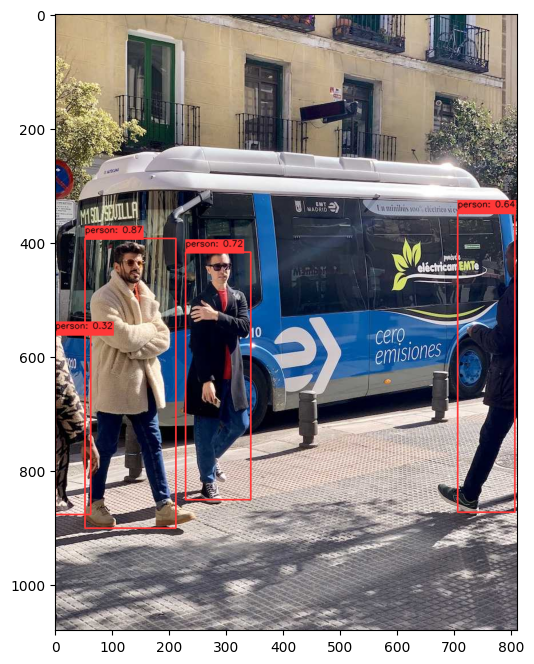

In [15]:
# 可视化
jshow(draw_img, 8)

In [16]:
# 保存
begin_time = time()
cv2.imwrite("jupyter_result.jpg", draw_img)
print("\033[1;31m" + f"cv2.imwrite time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

cv2.imwrite time = 23.57 ms
